<a href="https://colab.research.google.com/github/tleitch/HFstrategies21/blob/main/assignments/assignment%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Backtesting an ML strategy with Backtrader

## Imports & Settings

In [420]:
import warnings
warnings.filterwarnings('ignore')

In [421]:
!pip install backtrader
!pip install git+https://github.com/quantopian/pyfolio
!pip install yfinance
!pip install --upgrade tables
%matplotlib inline

from pathlib import Path
import csv
from time import time
import datetime
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import seaborn as sns

import backtrader as bt
from backtrader.feeds import PandasData

import pyfolio as pf

import bs4 as bs
import requests
import yfinance as yf
import datetime
from datetime import date

  Cloning https://github.com/quantopian/pyfolio to /tmp/pip-req-build-5luxq22l
  Running command git clone -q https://github.com/quantopian/pyfolio /tmp/pip-req-build-5luxq22l
  Created wheel for pyfolio: filename=pyfolio-0.9.2+75.g4b901f6-cp37-none-any.whl size=75776 sha256=748f6d97371ffab28566b202cdee7cebfce407f3525bddc2232c1ad87f6d9f95
  Stored in directory: /tmp/pip-ephem-wheel-cache-7rbaqzvv/wheels/62/7d/a7/3e462442ba7d63c35414176627c886340521dc3dbc0893ce9f
Successfully built pyfolio
Requirement already up-to-date: tables in /usr/local/lib/python3.7/dist-packages (3.6.1)


In [422]:
pd.set_option('display.expand_frame_repr', False)
np.random.seed(42)
sns.set_style('darkgrid')

In [423]:
def format_time(t):
    m_, s = divmod(t, 60)
    h, m = divmod(m_, 60)
    return f'{h:>02.0f}:{m:>02.0f}:{s:>02.0f}'

## Backtrader Setup

### Custom Commission Scheme

In [424]:
class FixedCommisionScheme(bt.CommInfoBase):
    """
    Simple fixed commission scheme for demo
    """
    params = (
        ('commission', .02),
        ('stocklike', True),
        ('commtype', bt.CommInfoBase.COMM_FIXED),
    )

    def _getcommission(self, size, price, pseudoexec):
        return abs(size) * self.p.commission

### DataFrame Loader

In [425]:
OHLCV = ['open', 'high', 'low', 'close', 'volume']

In [426]:
class SignalData(PandasData):
    """
    Define pandas DataFrame structure
    """
    cols = OHLCV + ['predicted']

    # create lines
    lines = tuple(cols)

    # define parameters
    params = {c: -1 for c in cols}
    params.update({'datetime': None})
    params = tuple(params.items())

### Strategy

Includes an option to only trade on certain weekdays in lines 39/40.

In [470]:
# assignment 2 -- This is how you decide to go long using a simple moving average
# You can change the fast and slow moving averages here 

class SmaCrossLong(bt.Strategy):
    # list of parameters which are configurable for the strategy
    params = dict(
        pfast=10,  # period for the fast moving average
        pslow=30   # period for the slow moving average

    )


    def __init__(self):
        sma1 = bt.ind.SMA(period=self.p.pfast)  # fast moving average
        sma2 = bt.ind.SMA(period=self.p.pslow)  # slow moving average
        self.crossover = bt.ind.CrossOver(sma1, sma2)  # crossover signal
        positions = [d._name for d, pos in self.getpositions().items() if pos]

    def next(self):
      for ticker in tickers:
        if ticker not in positions:  # not in the market
            if self.crossover > 0:  # if fast crosses slow to the upside
                #self.buy()  # enter long
                long_target = 1 / (2*len(tickers))
                self.order_target_percent(data=ticker, target=long_target)

        elif self.crossover < 0:  # in the market & cross to the downside
                 self.close()  # close long position

In [474]:
# assignment 2 -- This is how you decide to go short using a simple moving average
# You can change the fast and slow moving averages here 

class SmaCrossShort(bt.Strategy):
    # list of parameters which are configurable for the strategy
    params = dict(
        pfast=15,  # period for the fast moving average
        pslow=35   # period for the slow moving average
    )

    def __init__(self):
        sma3 = bt.ind.SMA(period=self.p.pfast)  # fast moving average
        sma4 = bt.ind.SMA(period=self.p.pslow)  # slow moving average
        self.crossover = bt.ind.CrossOver(sma3, sma4)  # crossover signal
        positions = [d._name for d, pos in self.getpositions().items() if pos]


    def next(self):
      for ticker in tickers:
        if ticker not in positions:  # not in the market
            if self.crossover < 0:  # if fast crosses slow to the downside
                #self.sell()  # enter short
                short_target = -1 / (2*len(tickers))
                self.order_target_percent(data=ticker, target=short_target)

        elif self.crossover > 0:  # in the market & cross to the upside
               self.close()  # close short position

### Create and Configure Cerebro Instance

In [475]:
cerebro = bt.Cerebro()  # create a "Cerebro" instance

cash = 10000
comminfo = FixedCommisionScheme()
cerebro.broker.addcommissioninfo(comminfo)#
cerebro.broker.setcash(cash)

### Add input data

In [476]:
# Assignment 2 -- Here is where you add/choose tickers - data comes from yahoo finance


tickers = ["AAPL","AMZN","FB","GE"]
for ticker in tickers:
    data = bt.feeds.YahooFinanceData(dataname=ticker,
                                 fromdate=datetime.datetime(2018, 1, 1),
                                 todate=datetime.datetime(2020, 12, 31))
    cerebro.adddata(data,name=ticker)


### Run Strategy Backtest

In [477]:
# Assignment 2 -- Run strategy. Look at changing n_positon and min_positions as you add tickers
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
#cerebro.addstrategy(MLStrategy, n_positions=0, min_positions=0, 
#                    verbose=True, log_file='bt_log.csv')
#data = bt.feeds.YahooFinanceData(dataname='MSFT',
#                                 fromdate=datetime.datetime(2019, 12, 31),
#                                 todate=datetime.datetime(2020, 12, 31))
#cerebro.adddata(data)  # Add the data feed

cerebro.addstrategy(SmaCrossLong)
cerebro.addstrategy(SmaCrossShort)
start = time()
results = cerebro.run()
ending_value = cerebro.broker.getvalue()
duration = time() - start

print(f'Final Portfolio Value: {ending_value:,.2f}')
print(f'Duration: {format_time(duration)}')

Final Portfolio Value: 9,828.05
Duration: 00:00:03


### Plot result

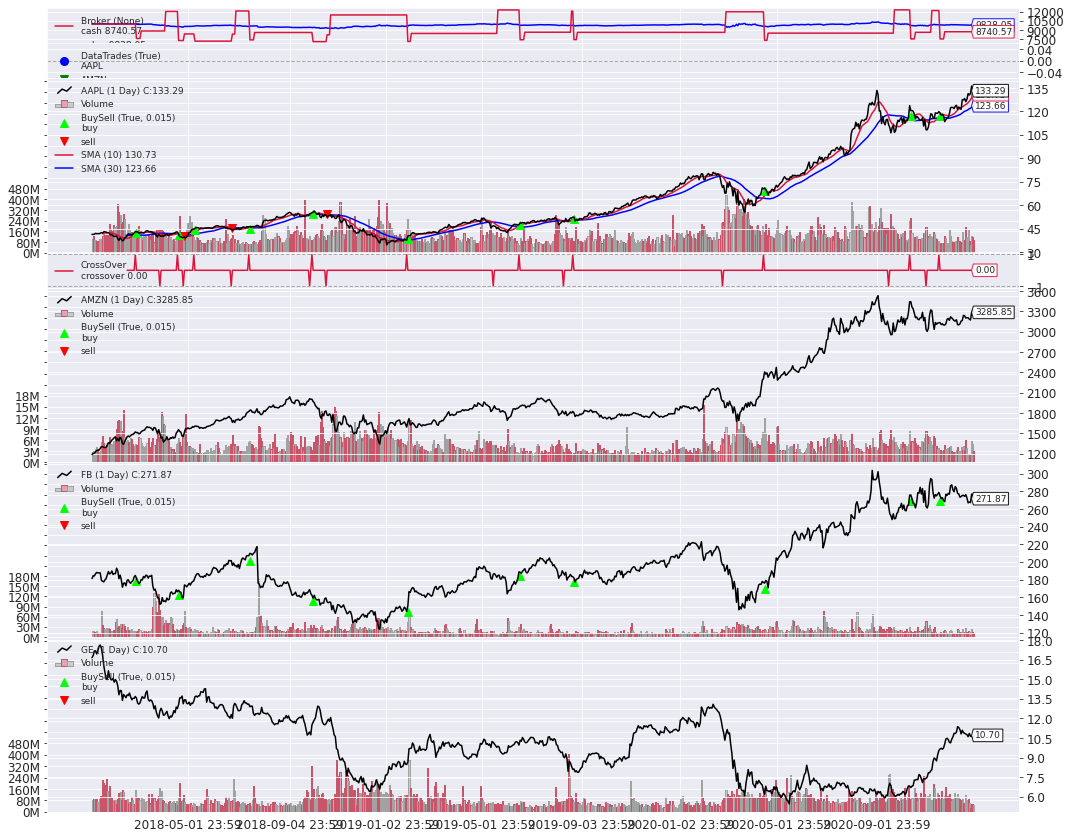

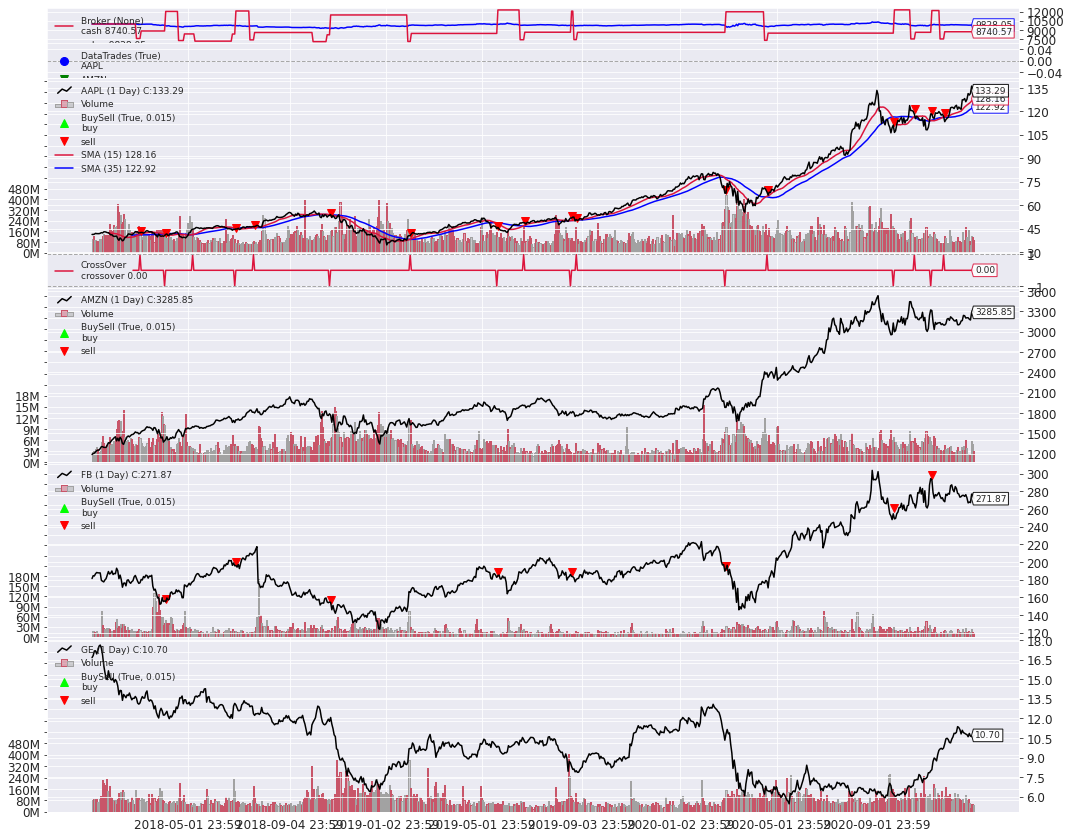

[[<Figure size 1080x864 with 11 Axes>], [<Figure size 1080x864 with 11 Axes>]]

In [478]:
%matplotlib inline


plt.rcParams['figure.figsize'] = [15, 12]
plt.rcParams.update({'font.size': 12}) 
cerebro.plot(iplot = False)

Disabled because large number of datafeeds all plot separately.

### Get `pyfolio` inputs

In [433]:
# prepare pyfolio inputs
pyfolio_analyzer = results[0].analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfolio_analyzer.get_pf_items()

returns.to_hdf('backtrader.h5', 'returns')
positions.to_hdf('backtrader.h5', 'positions')
transactions.to_hdf('backtrader.h5', 'transactions/')
gross_lev.to_hdf('backtrader.h5', 'gross_lev')

## Run pyfolio analysis

In [434]:
returns = pd.read_hdf('backtrader.h5', 'returns')
positions = pd.read_hdf('backtrader.h5', 'positions')
transactions = pd.read_hdf('backtrader.h5', 'transactions/')
gross_lev = pd.read_hdf('backtrader.h5', 'gross_lev')

In [435]:
benchmark = web.DataReader('SP500', 'fred', start = date (2017, 1, 1), end = date (2020, 12, 31)).squeeze()
benchmark = benchmark.pct_change().tz_localize('UTC')

In [436]:
benchmark=benchmark.dropna()

In [437]:
daily_tx = transactions.groupby(level=0)
longs = daily_tx.value.apply(lambda x: x.where(x>0).sum())
shorts = daily_tx.value.apply(lambda x: x.where(x<0).sum())

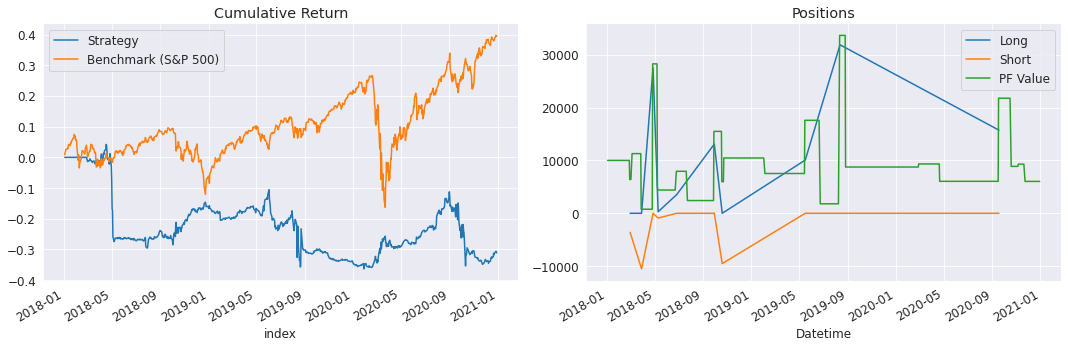

In [438]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))

df = returns.to_frame('Strategy').join(benchmark.to_frame('Benchmark (S&P 500)'))
df.add(1).cumprod().sub(1).plot(ax=axes[0], title='Cumulative Return')

longs.plot(label='Long',ax=axes[1], title='Positions')
shorts.plot(ax=axes[1], label='Short')
positions.cash.plot(ax=axes[1], label='PF Value')
axes[1].legend()
sns.despine()
fig.tight_layout();

Start date,2018-01-02
End date,2020-12-30
Total months,35
,Backtest
Annual return,-11.694%
Cumulative returns,-31.105%
Annual volatility,26.865%
Sharpe ratio,-0.33
Calmar ratio,-0.30
Stability,0.35
Max drawdown,-38.887%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,38.89,2018-04-17,2020-01-29,NaT,NaN
1,2.79,2018-02-26,2018-03-26,2018-04-04,28
2,2.28,2018-04-05,2018-04-06,2018-04-10,4
3,0.33,2018-04-10,2018-04-11,2018-04-12,3
4,NaN,NaT,NaT,NaT,NaN


Top 10 long positions of all time,max
GE,61.86%


Top 10 short positions of all time,max
GE,-91.80%


Top 10 positions of all time,max
GE,91.80%


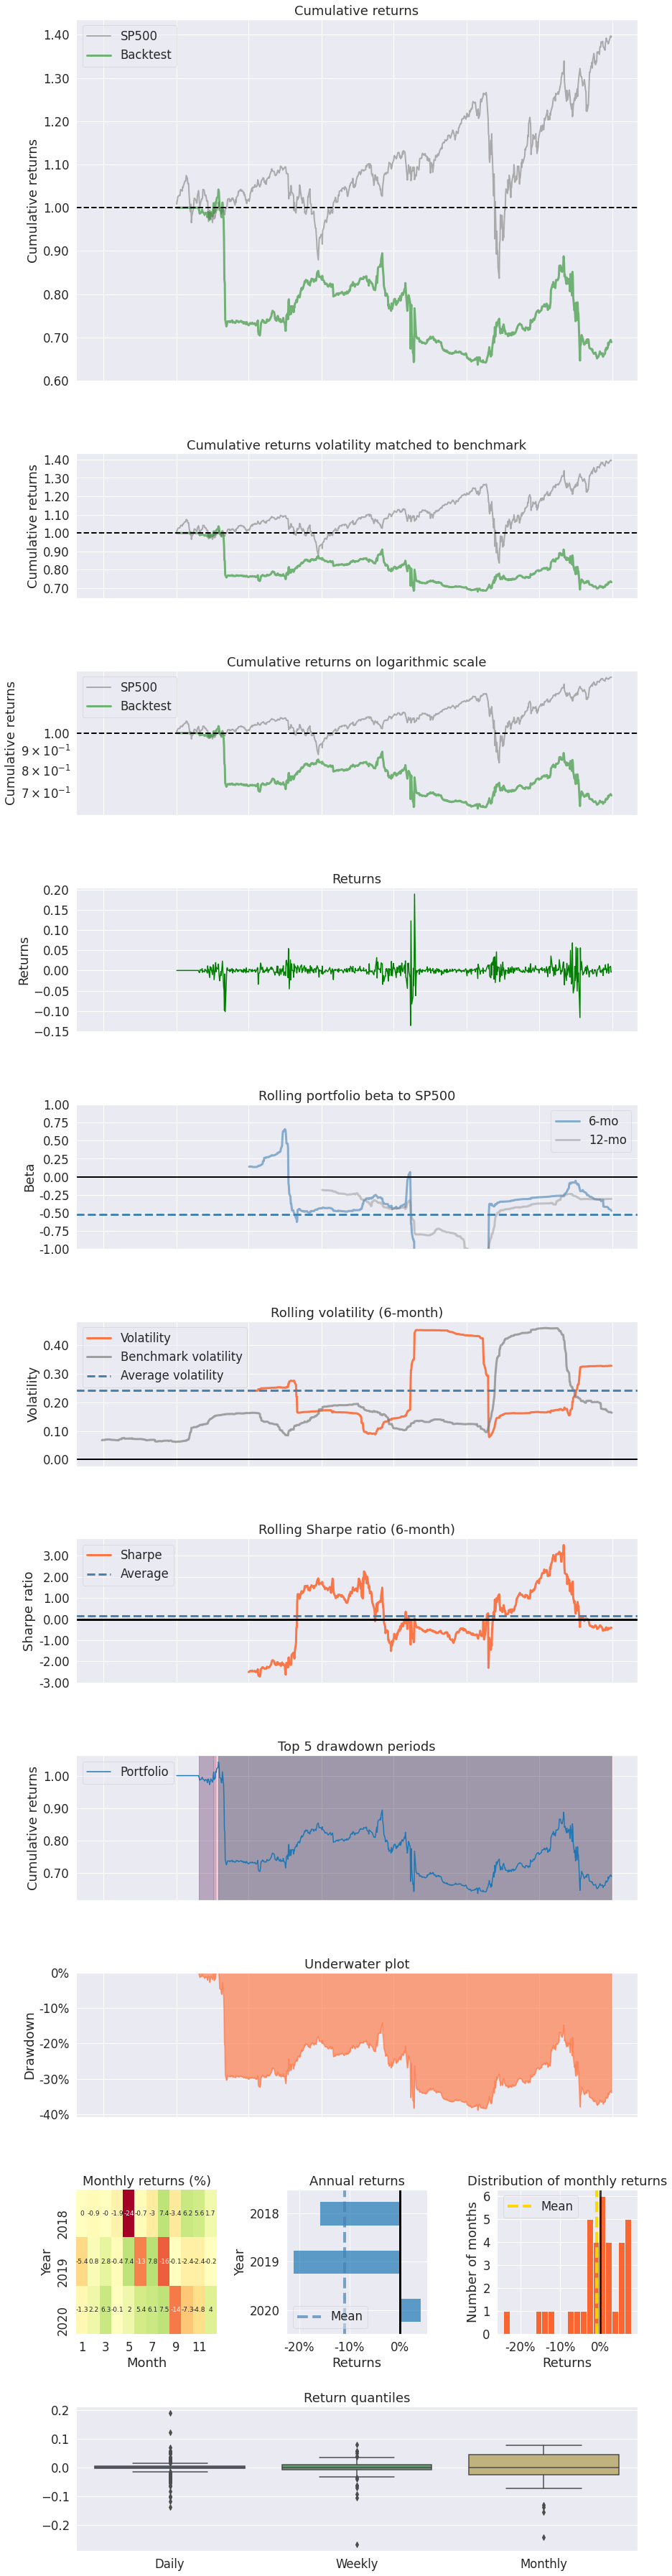

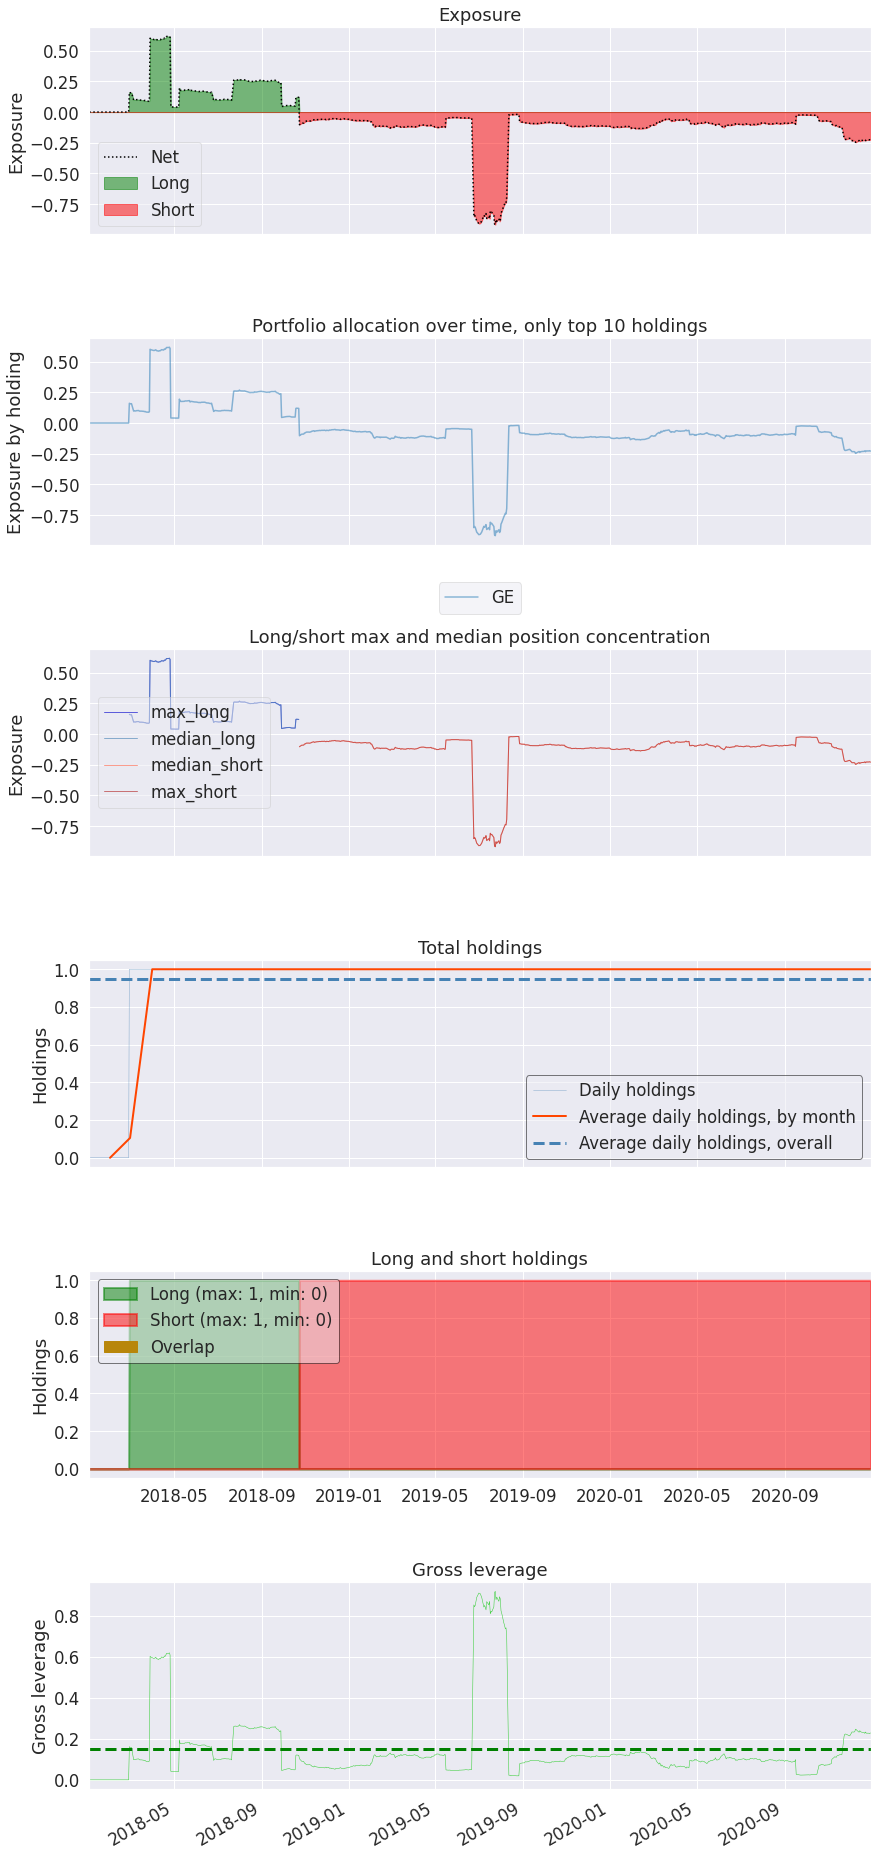

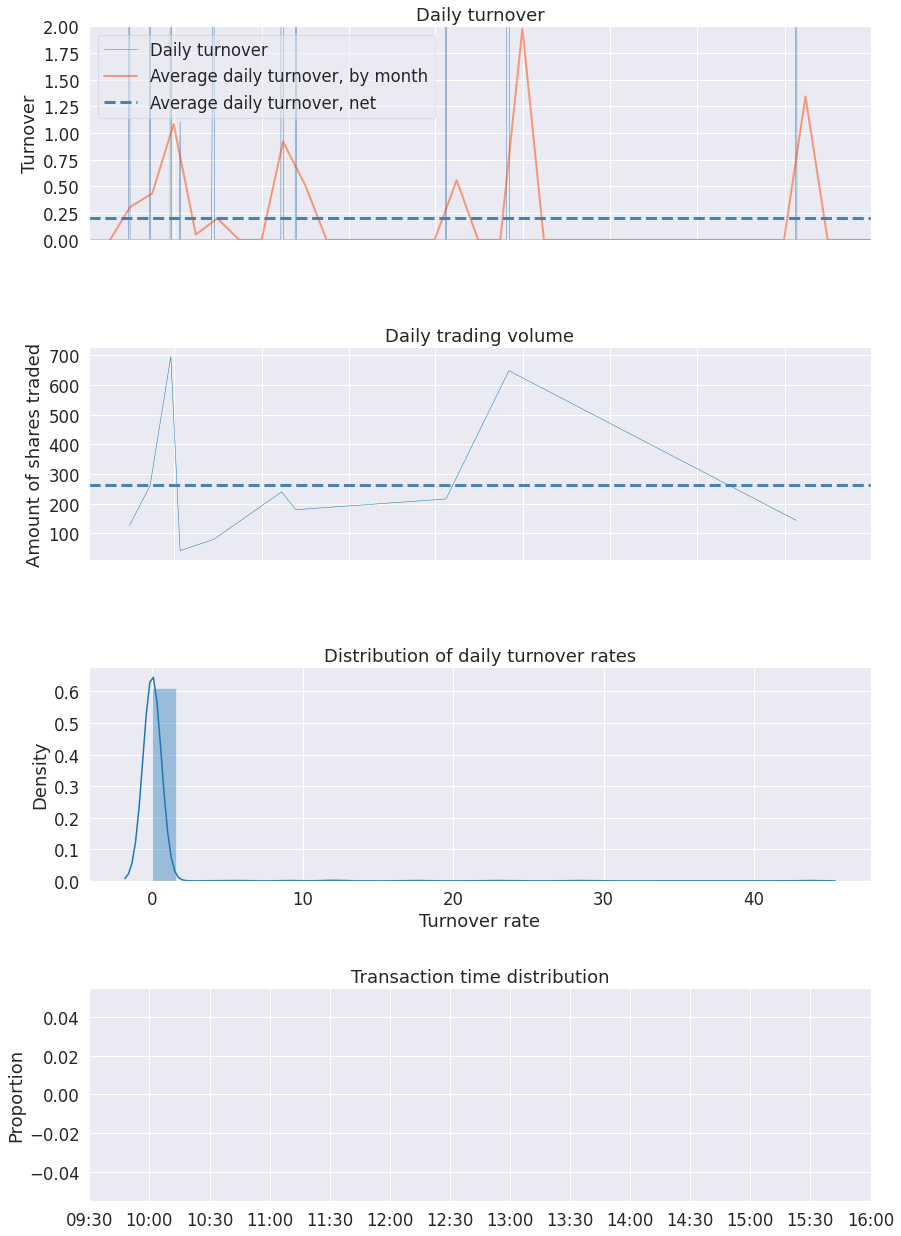

In [439]:
pf.create_full_tear_sheet(returns,
                          transactions=transactions,
                          positions=positions,
                          benchmark_rets=benchmark.dropna())